In [1]:
# =============================================================================
# Notebook: 00_CAC40.ipynb
# Purpose : Baseline CAC40 time-series research (returns, stationarity, volatility)
# =============================================================================

# --- Standard Library ---
from __future__ import annotations

import itertools # Hyperparameter grid searching (windows, lags, etc.)
from datetime import datetime, timedelta # Time window management for sliding/walk-forward windows
import warnings

# --- Data Handling & Math ---
import numpy as np # Vectorized operations on returns and signals
import pandas as pd # Core TimeSeries container (OHLCV data)
import yfinance as yf # Quick ingestion of historical market data

# --- Statistics & Diagnostics ---
from scipy.stats import jarque_bera, shapiro # Normality tests for return distributions
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller (ADF) for unit root/stationarity
from statsmodels.stats.diagnostic import het_arch # Test for ARCH effects (volatility clustering)
from statsmodels.stats.diagnostic import acorr_ljungbox # Test for remaining autocorrelation in residuals

# --- Time Series Econometrics / Volatility Models ---
from arch import arch_model # GARCH models for volatility forecasting/regime detection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Identifying significant lags for retraining

# --- Visualization ---
import matplotlib.pyplot as plt # Plotting equity curves, drawdowns, and price/signal overlays

# --- Notebook Runtime Settings ---
warnings.filterwarnings("ignore")  # keep notebooks readable; tighten later for production
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Matplotlib defaults (kept minimal; avoid heavy styling for reproducibility)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True


## Data Ingestion & Persistence
> This section handles the data acquisition for the **CAC 40 (^FCHI)**. 
> To ensure reproducibility and speed, we implement a **local caching mechanism**:
> 1. We check if a local `.parquet` file exists in the `data/` directory.
> 2. If it exists, we load it to avoid unnecessary API calls.
> 3. If not, we fetch the data from Yahoo Finance and serialize it locally for future use.
>
> 

In [2]:
# =============================================================================
# Data Ingestion & Persistence — CAC 40 (^FCHI)
# =============================================================================
# - Prefer local Parquet cache for speed and reproducibility
# - Fallback to Yahoo Finance only if cache is missing
# - Normalize index/columns for clean downstream analysis
# =============================================================================

import os
from pathlib import Path

# -------------------------------------------------------------------------
# Configuration
# -------------------------------------------------------------------------
ticker = "^FCHI"
start_date = "2000-01-01"
end_date = "2025-12-31"

# Note: notebook is in notebooks/00_analysis/, so ../data -> notebooks/data/
cache_dir = Path("../data")
cache_dir.mkdir(parents=True, exist_ok=True)

cache_file = cache_dir / f"{ticker.replace('^', '')}_{start_date}_{end_date}.parquet"

# -------------------------------------------------------------------------
# Load from cache or fetch from Yahoo Finance
# -------------------------------------------------------------------------
if cache_file.exists():
    print(f"--- Loading data from cache: {cache_file} ---")
    data = pd.read_parquet(cache_file)

else:
    print(f"--- Fetching data for {ticker} from Yahoo Finance ---")

    yf_ticker = yf.Ticker(ticker)
    data = yf_ticker.history(
        start=start_date,
        end=end_date,
        auto_adjust=False, # keep raw OHLCV (safer for quant work)
        repair=True # attempt to fix minor data issues
    )

    # Basic sanity checks before persisting
    if data is None or data.empty:
        raise RuntimeError(
            f"No data returned for {ticker} between {start_date} and {end_date}"
        )

    # Normalize index and columns for downstream consistency
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()

    # Keep only OHLCV if present; drop Yahoo extras (Dividends, Stock Splits, etc.)
    keep_cols = [c for c in ["Open", "High", "Low", "Close", "Volume", "Adj Close"] if c in data.columns]
    data = data[keep_cols]

    # Persist to Parquet for future runs
    data.to_parquet(cache_file)
    print(f"--- Data saved to: {cache_file} ---")

# -------------------------------------------------------------------------
# Minimal validation
# -------------------------------------------------------------------------
required = {"Open", "High", "Low", "Close", "Adj Close"}
missing = required - set(data.columns)
if missing:
    raise ValueError(f"Missing required OHLC columns: {missing}")

# -------------------------------------------------------------------------
# Preview
# -------------------------------------------------------------------------
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min()} → {data.index.max()}")
data.head()


--- Loading data from cache: ../data/FCHI_2000-01-01_2025-12-31.parquet ---
Shape: (6644, 6)
Date range: 2000-01-03 00:00:00+01:00 → 2025-12-30 00:00:00+01:00


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2000-01-03 00:00:00+01:00,6024.379883,6102.120117,5901.770020,5917.370117,0,5917.370117
2000-01-04 00:00:00+01:00,5922.229980,5925.069824,5657.200195,5672.020020,0,5672.020020
2000-01-05 00:00:00+01:00,5521.830078,5589.500000,5461.589844,5479.700195,0,5479.700195
2000-01-06 00:00:00+01:00,5485.930176,5530.259766,5388.850098,5450.109863,0,5450.109863
2000-01-07 00:00:00+01:00,5423.879883,5561.689941,5423.879883,5539.609863,0,5539.609863


### Markdown Cell: Exploratory Data Analysis - Visual Inspection

> Before applying statistical tests, we perform a **Visual Inspection** of the time series. This step is crucial to identify:
> 1. **Trend**: Does the series move around a constant mean (stationary) or does it exhibit a long-term direction (non-stationary)?
> 2. **Seasonality**: Are there recurring patterns at fixed intervals?
> 3. **Variance**: Does the fluctuation amplitude change over time (**Heteroskedasticity**)?
> 4. **Structural Breaks**: Major market shocks that might require a model reset.
> 
> 

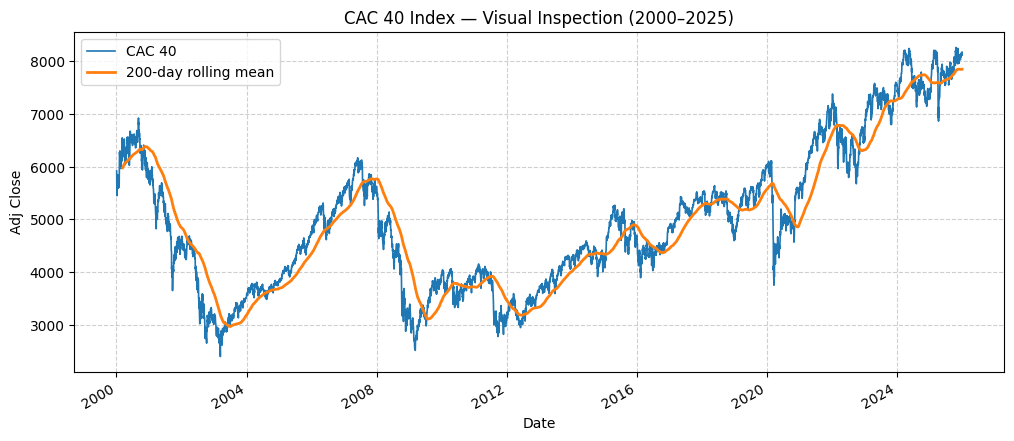

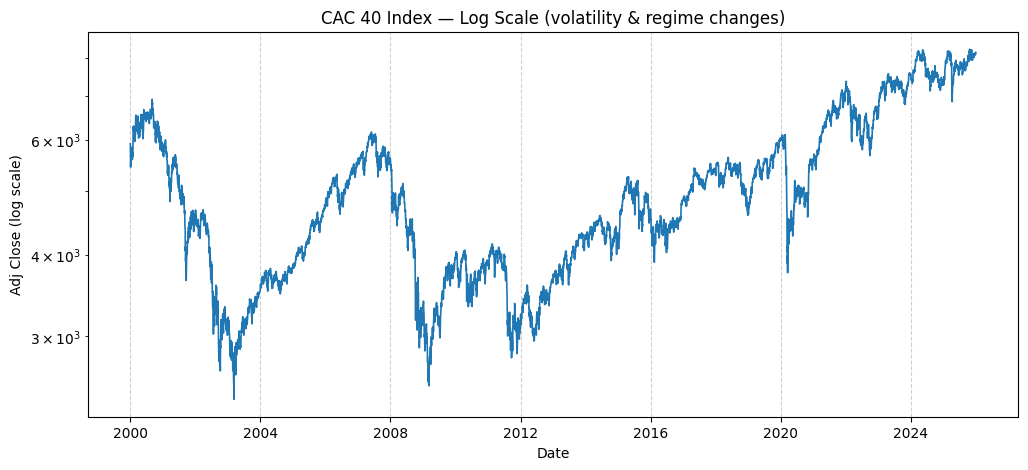

In [3]:
# =============================================================================
# Exploratory Data Analysis — Visual Inspection (Level 1)
# =============================================================================
# Objectives:
# 1) Detect long-term trend (stationarity vs. drift)
# 2) Identify potential structural breaks or crisis periods
# 3) Assess volatility clustering (heteroskedasticity)
# =============================================================================

# Prefer Adj Close if available, otherwise fallback to Close
price_col = "Adj Close" if "Adj Close" in data.columns else "Close"
cac40 = data[price_col].loc[:end_date]

# Quick sanity preview
cac40.head()

# -----------------------------------------------------------------------------
# Plot 1 — Raw price series (linear scale)
# -----------------------------------------------------------------------------
plt.plot(cac40.index, cac40, linewidth=1.2, label="CAC 40")

# Add a long-term smoothing to visualize trend (200-day rolling mean)
cac40.rolling(window=200, min_periods=50).mean().plot(
    linewidth=2.0, label="200-day rolling mean"
)

plt.title("CAC 40 Index — Visual Inspection (2000–2025)")
plt.xlabel("Date")
plt.ylabel(f"{price_col}")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left")

plt.show()

# -----------------------------------------------------------------------------
# Plot 2 — Log scale (better for volatility / multiplicative dynamics)
# -----------------------------------------------------------------------------
plt.plot(cac40.index, cac40, linewidth=1.2)
plt.yscale("log")  # Important for financial time series

plt.title("CAC 40 Index — Log Scale (volatility & regime changes)")
plt.xlabel("Date")
plt.ylabel(f"{price_col} (log scale)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


### From Prices to Returns: Why We Change Perspective

The visual inspection of the **CAC 40 price level** suggests that the series is **not stationary**:  
it exhibits long-term trends, regime shifts, and large swings in magnitude. This is expected for
financial price series and makes many statistical tests (e.g., ADF, ARCH, ARMA) invalid **on prices directly**.

To address this, we analyze **returns instead of prices**. Returns represent *relative* changes in value and
typically:

- Remove most deterministic trends,
- Stabilize the variance over time,
- Make the series more amenable to stationarity tests,
- Better reflect the quantity that investors actually care about (gains and losses).

We focus on **log returns**, defined as:

$$
r_t = \ln(P_t) - \ln(P_{t-1})
$$

Log returns are preferred in quantitative finance because they are:
- Time-additive,
- Symmetric for gains and losses,
- Consistent with continuous-time models used in econometrics and risk management.

In the next cell, we compute and visually inspect the daily log returns of the CAC 40.


Returns shape: (6643,)
Date range: 2000-01-04 00:00:00+01:00 → 2025-12-30 00:00:00+01:00


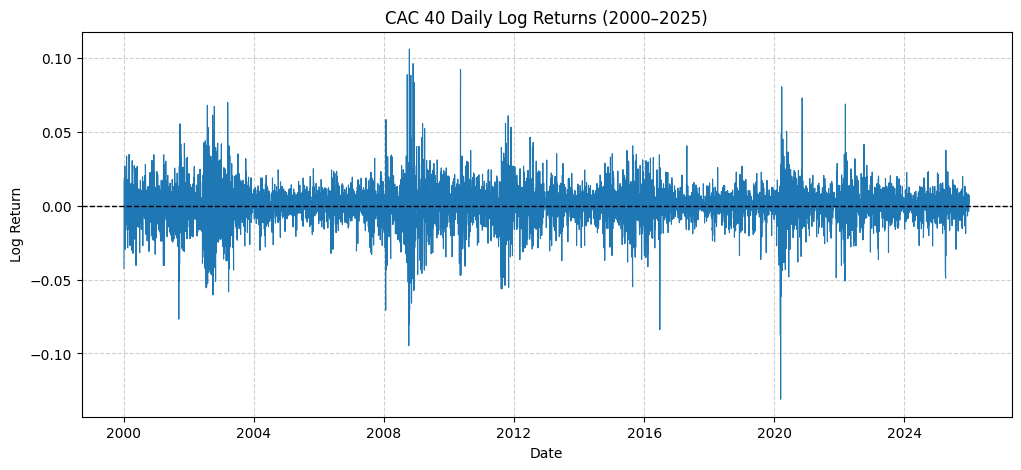

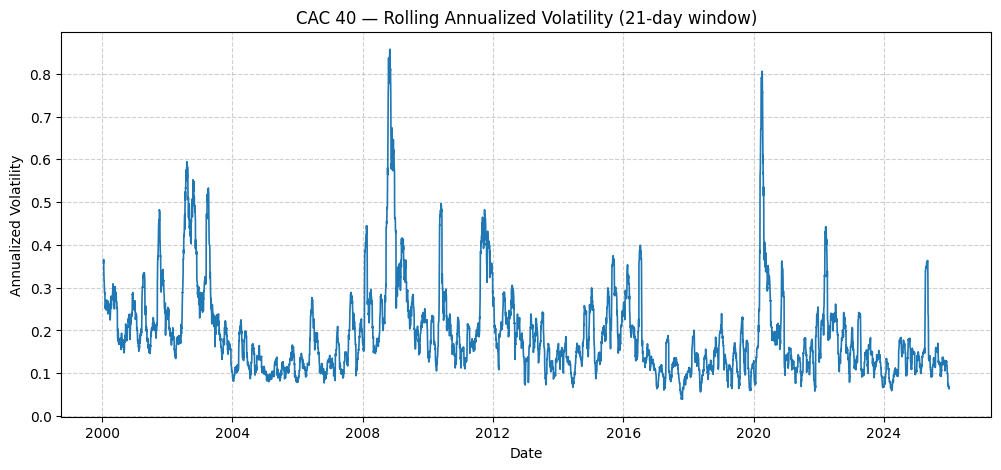

In [4]:
# =============================================================================
# Returns Computation & Visual Inspection
# =============================================================================
# Compute daily log returns and inspect their dynamics visually
# =============================================================================

# Select price series (robust fallback)
price_col = "Adj Close" if "Adj Close" in data.columns else "Close"
prices = data[price_col].loc[:end_date]

# Compute daily log returns
returns = np.log(prices / prices.shift(1)).dropna()
returns.name = "CAC40 Log Returns"

# Quick sanity check
print(f"Returns shape: {returns.shape}")
print(f"Date range: {returns.index.min()} → {returns.index.max()}")
returns.head()

# -----------------------------------------------------------------------------
# Plot 1 — Time series of log returns (stationarity visual check)
# -----------------------------------------------------------------------------
plt.plot(returns.index, returns, linewidth=0.8)
plt.axhline(0, color="black", linewidth=1.0, linestyle="--")

plt.title("CAC 40 Daily Log Returns (2000–2025)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

# -----------------------------------------------------------------------------
# Plot 2 — Rolling volatility (visual check for heteroskedasticity)
# -----------------------------------------------------------------------------
rolling_vol = returns.rolling(window=21, min_periods=10).std() * np.sqrt(252)

plt.plot(rolling_vol.index, rolling_vol, linewidth=1.2)
plt.title("CAC 40 — Rolling Annualized Volatility (21-day window)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


### From Visual Intuition to Formal Time-Series Diagnostics

Our preliminary **visual inspection** led to two key empirical observations:

1. **Price levels are non-stationary**  
   The CAC 40 index exhibits clear long-term trends, structural breaks, and regime shifts.  
   This behavior is typical of financial prices and suggests that statistical inference on
   the raw price series is likely to be unreliable without transformation.

2. **Returns appear much closer to stationarity**  
   After transforming prices into log returns, the series fluctuates around a stable mean
   with no obvious deterministic trend. This is consistent with standard assumptions in
   financial econometrics.

3. **Volatility clustering is visually evident**  
   Periods of large fluctuations in returns tend to be followed by further large fluctuations,
   while calmer periods tend to persist — a hallmark of conditional heteroskedasticity
   (ARCH/GARCH behavior).

---

### Next Step: Autocorrelation Analysis on Prices

Before formally testing stationarity and modeling volatility, we first examine the **autocorrelation structure of the price series** using:

- The **Autocorrelation Function (ACF)** — to assess persistence and long-memory behavior,
- The **Partial Autocorrelation Function (PACF)** — to identify the potential order of an AR process.

If prices are truly non-stationary (e.g., integrated of order 1), we expect:
- A slowly decaying ACF,
- Significant autocorrelations at many lags,
- A PACF that does not cut off sharply.

We now compute and visualize the ACF and PACF of the CAC 40 price level.


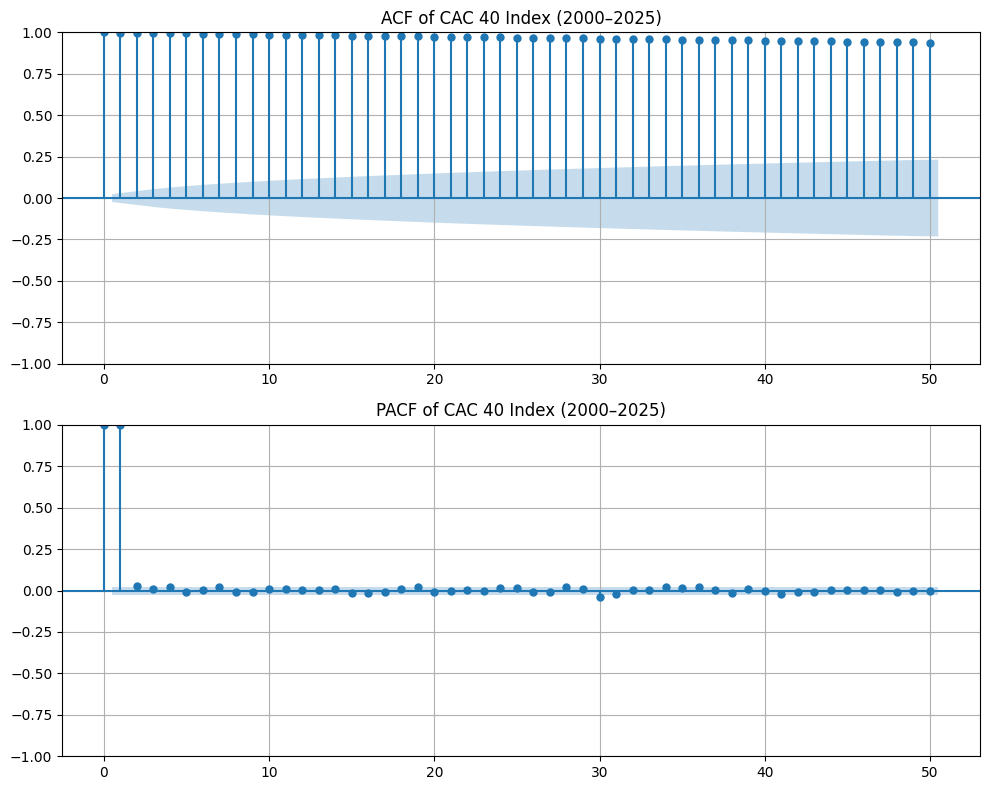

In [5]:
# =============================================================================
# Autocorrelation Analysis — Price Level (CAC 40)
# =============================================================================
# Objective:
# - Confirm visually suspected non-stationarity of the price series
# - Inspect persistence structure via ACF and PACF
# =============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# -------------------------------------------------------------------------
# ACF: measures correlation of the series with its own past values
# -------------------------------------------------------------------------
# For a non-stationary (integrated) series, we typically expect:
# - Slow decay of autocorrelations
# - Many significant lags
plot_acf(cac40, lags=50, ax=ax1)
ax1.set_title("ACF of CAC 40 Index (2000–2025)")

# -------------------------------------------------------------------------
# PACF: controls for intermediate lags, useful for AR order identification
# -------------------------------------------------------------------------
# For a stationary AR(p) process, PACF should cut off after lag p.
# For non-stationary series, PACF often remains significant at many lags.
plot_pacf(cac40, lags=50, ax=ax2)
ax2.set_title("PACF of CAC 40 Index (2000–2025)")

plt.tight_layout()
plt.show()


### Autocorrelation Analysis on Returns: From Non-Stationary Prices to Stationary Dynamics

The ACF of the **price level** confirmed our earlier visual intuition: the slow decay of
autocorrelations is consistent with a non-stationary (near unit-root) process.

We now shift our focus to **log returns**, which are expected to behave very differently.

Our objectives in this step are to examine whether:

1. **Linear dependence is largely absent in returns**  
   If returns are (approximately) weakly stationary, we should observe:
   - ACF values close to zero beyond very short lags,
   - A PACF that cuts off quickly, indicating little predictable linear structure.

2. **Volatility dependence remains present**  
   Even if returns show little linear autocorrelation, this does **not** imply independence.
   Financial returns often display:
   - No significant autocorrelation in levels,
   - But strong dependence in squared or absolute returns (volatility clustering).

This distinction is crucial:
- ACF/PACF on returns help assess **predictability of the mean**,  
- But they do **not** capture volatility dynamics — which we will test later using ARCH diagnostics.

We now compute the ACF and PACF of the daily log returns to verify these expectations.


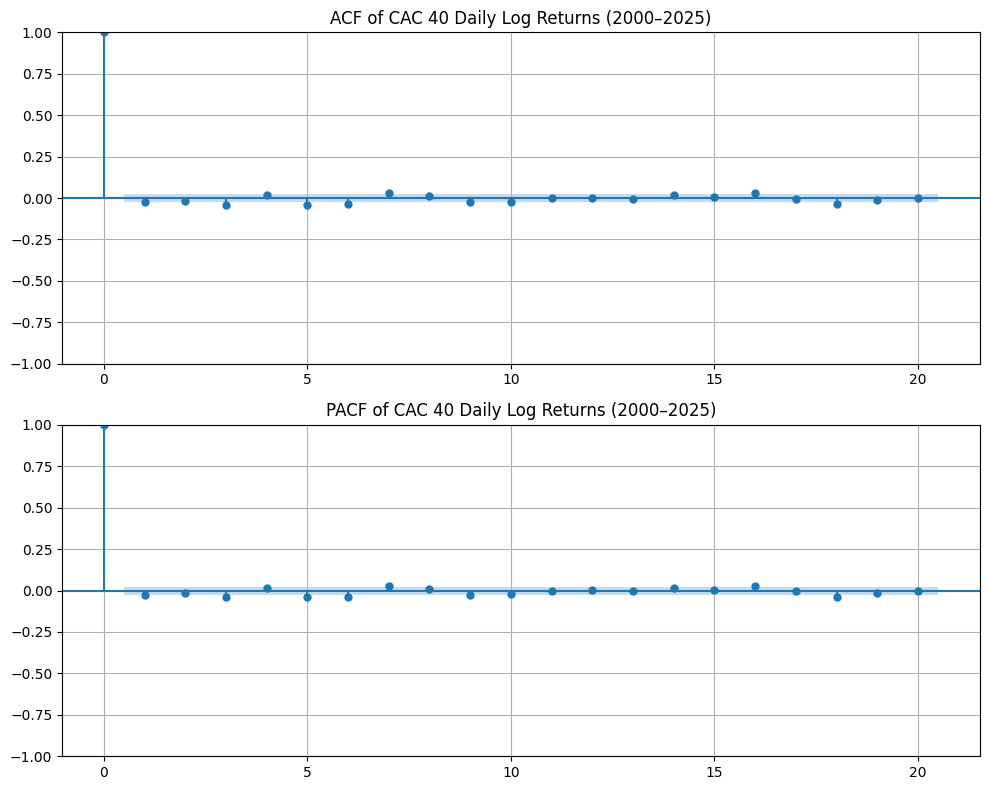

In [6]:
# =============================================================================
# Autocorrelation Analysis — Log Returns (CAC 40)
# =============================================================================
# Objective:
# - Verify whether returns exhibit significant linear autocorrelation
# - Contrast with the highly persistent structure observed in prices
# =============================================================================

fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

# -------------------------------------------------------------------------
# ACF of returns: tests for linear dependence in the mean
# -------------------------------------------------------------------------
# For a (weakly) stationary return series, we typically expect:
# - Most autocorrelations within confidence bounds after very short lags
# - No long-range persistence as seen in price levels
plot_acf(returns, ax=ax[0], lags=20, alpha=0.05)
ax[0].set_title("ACF of CAC 40 Daily Log Returns (2000–2025)")

# -------------------------------------------------------------------------
# PACF of returns: useful for detecting short AR structures
# -------------------------------------------------------------------------
# If returns were well-described by a low-order AR(p) process,
# the PACF would cut off sharply after lag p.
# In practice, financial returns usually show little such structure.
plot_pacf(returns, ax=ax[1], lags=20, alpha=0.05)
ax[1].set_title("PACF of CAC 40 Daily Log Returns (2000–2025)")

plt.tight_layout()
plt.show()


### Formal Stationarity Test on Returns (Augmented Dickey–Fuller)

The ACF and PACF of the **log returns** suggested an absence of linear autocorrelation:
the series behaves similarly to white noise in its mean dynamics. This implies that
predicting *expected returns* with a simple linear time-series model would likely be ineffective.

However, we previously observed clear **volatility clustering**, indicating that while
returns may be unpredictable in mean, their **variance is not constant over time**.
This motivates the use of a **GARCH-type model** for volatility prediction.

Before estimating such a model, we first need to formally verify that the return series
is (weakly) stationary. For this purpose, we apply the **Augmented Dickey–Fuller (ADF) test**.

The ADF test evaluates the null hypothesis:

- **H₀ (non-stationary):** The series has a unit root.
- **H₁ (stationary):** The series is stationary.

If the test statistic is more negative than the critical values, and the p-value is below
a conventional threshold (e.g., 5%), we reject H₀ and conclude that the series is stationary.

We now perform the ADF test on daily log returns.


In [7]:
# =============================================================================
# Stationarity Test — Augmented Dickey–Fuller (ADF) on Returns
# =============================================================================
# Objective:
# - Statistically confirm whether log returns are stationary
# - Provide formal justification before fitting a GARCH model
# =============================================================================

# Run ADF test
result = adfuller(returns)

# Unpack and report key statistics
adf_stat = result[0]
p_value = result[1]
crit_1 = result[4]["1%"]
crit_5 = result[4]["5%"]
crit_10 = result[4]["10%"]

print("ADF test statistic:", adf_stat)
print("Critical value 1%:", crit_1)
print("Critical value 5%:", crit_5)
print("Critical value 10%:", crit_10)
print("P-value:", p_value)

# Decision rule (5% significance level)
is_stationary = p_value < 0.05
print("Is stationary?", "Yes" if is_stationary else "No")

# Optional: explicit interpretation in code (for clarity in reports/notebooks)
if is_stationary:
    print(
        "Conclusion: We reject the null hypothesis of a unit root.\n"
        "Log returns can be treated as (weakly) stationary."
    )
else:
    print(
        "Conclusion: We fail to reject the null hypothesis of a unit root.\n"
        "Further transformations or detrending may be required."
    )


ADF test statistic: -14.598536876208478
Critical value 1%: -3.4313396885482064
Critical value 5%: -2.8619773587686903
Critical value 10%: -2.567002802566139
P-value: 4.202202511711939e-27
Is stationary? Yes
Conclusion: We reject the null hypothesis of a unit root.
Log returns can be treated as (weakly) stationary.


### Diagnosing Conditional Heteroskedasticity: Squared Returns

Having established that **log returns are (weakly) stationary**, we now turn to the dynamics
of **volatility** rather than the mean.

A key empirical regularity in financial time series is that:
- Returns themselves often show little linear autocorrelation,
- But their **variance is strongly dependent over time** (volatility clustering).

To investigate this, we analyze the **squared returns** \( r_t^2 \), which serve as a proxy
for realized volatility at each point in time.

Our objectives in this step are to examine whether:

1. **Squared returns exhibit persistence over time**  
   A slowly evolving pattern in \( r_t^2 \) would indicate volatility regimes (high-volatility
   and low-volatility periods).

2. **Autocorrelation is present in squared returns**  
   Significant ACF/PACF in \( r_t^2 \) suggests that past volatility contains information
   about future volatility — a necessary condition for ARCH/GARCH modeling.

If these features are present, they provide strong empirical support for specifying
a **GARCH-type model** to forecast conditional volatility.


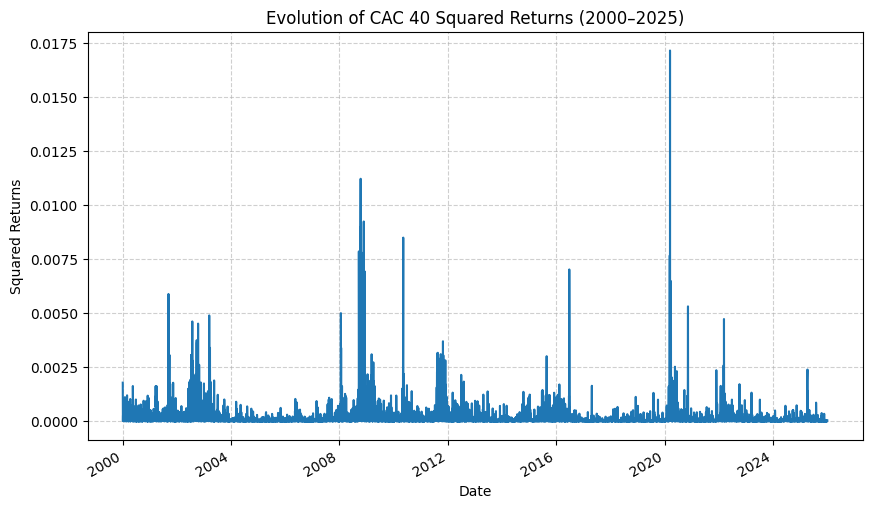

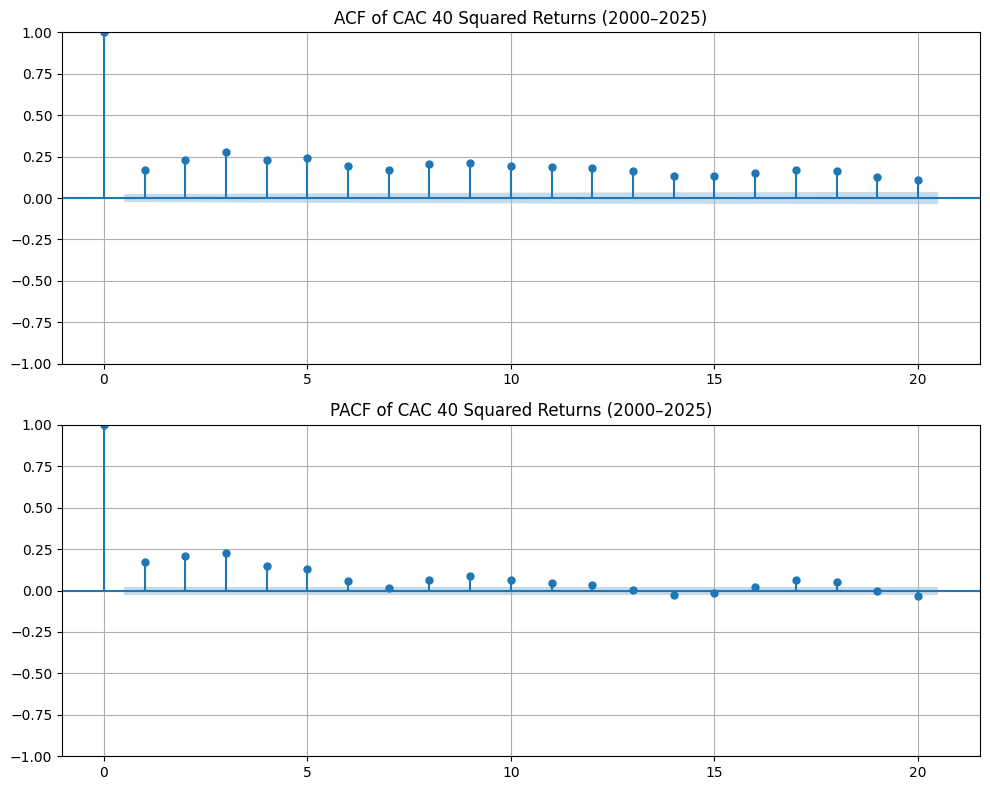

In [8]:
# =============================================================================
# Volatility Diagnostics — Squared Returns
# =============================================================================
# Objective:
# - Visually inspect volatility clustering
# - Examine autocorrelation structure of squared returns
# =============================================================================

# Compute squared returns (proxy for realized volatility)
returns_squared = returns**2

# -----------------------------------------------------------------------------
# Plot 1 — Time series of squared returns (volatility evolution)
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))

returns_squared.plot()
plt.title("Evolution of CAC 40 Squared Returns (2000–2025)")
plt.xlabel("Date")
plt.ylabel("Squared Returns")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

# -----------------------------------------------------------------------------
# Plot 2 — ACF / PACF of squared returns
# -----------------------------------------------------------------------------
# Significant autocorrelations here indicate conditional heteroskedasticity,
# i.e., today's volatility depends on past volatility (ARCH effect).
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

# ACF: persistence of volatility over time
plot_acf(returns_squared, ax=ax[0], lags=20, alpha=0.05)
ax[0].set_title("ACF of CAC 40 Squared Returns (2000–2025)")

# PACF: helps identify potential ARCH/GARCH orders
plot_pacf(returns_squared, ax=ax[1], lags=20, alpha=0.05)
ax[1].set_title("PACF of CAC 40 Squared Returns (2000–2025)")

plt.tight_layout()
plt.show()


### Volatility Modeling with GARCH: Model Selection via AIC

Our diagnostics support the following conclusions:

- The **price level** is non-stationary (trend / slow ACF decay).
- **Returns** are much closer to a weakly stationary process and show little linear autocorrelation
  (ACF/PACF consistent with a near white-noise mean).
- **Volatility is not constant over time**: squared returns exhibit persistence and significant
  autocorrelation, which is consistent with **conditional heteroskedasticity**.

This motivates the use of **ARCH/GARCH** models to describe and forecast the **conditional variance**
of returns.

We now perform a simple model selection exercise for **GARCH(p, q)** by fitting a grid of candidate
models and comparing them using the **Akaike Information Criterion (AIC)**:

- Lower AIC indicates a better trade-off between goodness of fit and model complexity.
- We will restrict ourselves to small orders (p, q in {1,2,3}) for stability and interpretability.

Because financial returns often exhibit fat tails, we also consider using a **Student-t**
innovation distribution, which is commonly more realistic than Gaussian residuals.


In [9]:
# =============================================================================
# GARCH(p, q) Grid Search — Model Selection via AIC
# =============================================================================
# Notes:
# - Use returns in percent for numerical stability
# - Assume zero mean (consistent with ACF/PACF suggesting no linear predictability)
# - Use Student-t innovations (fat tails typical in equity index returns)
# - Handle convergence failures gracefully
# =============================================================================

# Scale returns for numerical stability (e.g., 0.01 -> 1%)
r = (returns * 100).dropna()

p_range = range(1, 4)
q_range = range(1, 4)  # q=0 would be ARCH(p); keep q>=1 for true GARCH

rows = []

for p in p_range:
    for q in q_range:
        try:
            model = arch_model(
                r,
                mean="Zero",      # consistent with "white noise in mean"
                vol="GARCH",
                p=p,
                q=q,
                dist="t"          # more realistic than normal for returns
            )

            res = model.fit(disp="off")
            rows.append({
                "p": p,
                "q": q,
                "aic": res.aic,
                "bic": res.bic,
                "loglik": res.loglikelihood,
                "converged": bool(getattr(res, "convergence_flag", 0) == 0),
            })

        except Exception as e:
            # Record failures so the grid search remains transparent
            rows.append({
                "p": p,
                "q": q,
                "aic": np.nan,
                "bic": np.nan,
                "loglik": np.nan,
                "converged": False,
                "error": str(e)[:120],  # keep it short for display
            })

results_df = pd.DataFrame(rows).sort_values(by="aic", ascending=True)
results_df


,p,q,aic,bic,loglik,converged
3,2,1,20467.926771,20501.933366,-10228.963386,True
8,3,3,20467.960859,20522.371411,-10225.980430,True
4,2,2,20469.916069,20510.723983,-10228.958034,True
6,3,1,20469.926772,20510.734686,-10228.963386,True
7,3,2,20471.186617,20518.795849,-10228.593308,True
5,2,3,20471.188554,20518.797787,-10228.594277,True
0,1,1,20471.577447,20498.782723,-10231.788723,True
1,1,2,20473.577447,20507.584042,-10231.788724,True
2,1,3,20475.577448,20516.385362,-10231.788724,True


### GARCH Model Selection and Interpretation

We estimated a grid of **GARCH(p, q)** models with small orders (p, q ∈ {1, 2, 3}) and
compared them using the **Akaike Information Criterion (AIC)**.

The main results are summarized below:

- Several models provide very similar AIC values, indicating that volatility dynamics
  are well captured even with relatively low-order specifications.
- The lowest AIC is obtained for **GARCH(2,1)**.
- More complex models (e.g., GARCH(3,3)) do not provide a meaningful improvement in fit
  despite additional parameters.

This behavior is typical in financial time series:
- Volatility is highly persistent,
- But increasing model complexity beyond a certain point yields diminishing returns.

---

### Model Choice

Although **GARCH(2,1)** achieves the minimum AIC, the difference with **GARCH(1,1)**
is relatively small.

In practice, model selection should balance:
- Statistical fit (AIC/BIC),
- Parsimony,
- Interpretability,
- Stability and robustness of estimation.

For these reasons, we retain **GARCH(1,1)** as a baseline volatility model:
- It is widely used in empirical finance,
- It captures volatility clustering effectively,
- It is easier to interpret and forecast,
- It is less prone to overfitting.

The selected model will now be estimated and analyzed in detail.


### Estimation of the GARCH(1,1) Model

Based on the previous diagnostics, we retained a **GARCH(1,1)** specification to model
the conditional volatility of CAC 40 returns.

The model is defined as:

\[
r_t = \varepsilon_t, \quad \varepsilon_t = \sigma_t z_t
\]

\[
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
\]

where:
- \( \omega \) is the long-run variance component,
- \( \alpha \) captures the immediate impact of shocks (news effect),
- \( \beta \) measures volatility persistence,
- \( z_t \) follows a standardized Student-t distribution to account for fat tails.

The model is estimated by **maximum likelihood** under the assumption of zero mean,
which is consistent with the absence of linear autocorrelation in returns.

We now analyze the estimated parameters and their implications.


In [10]:
model = arch_model(r, mean='Zero', vol='Garch', p=1, q=1, dist='t')
results = model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 209119.96226617944
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12164.52614232742
Iteration:      3,   Func. Count:     22,   Neg. LLF: 10271.660193351945
Iteration:      4,   Func. Count:     28,   Neg. LLF: 10273.906633454342
Iteration:      5,   Func. Count:     34,   Neg. LLF: 10271.484080017759
Iteration:      6,   Func. Count:     40,   Neg. LLF: 10369.143727155373
Iteration:      7,   Func. Count:     47,   Neg. LLF: 10232.264936625466
Iteration:      8,   Func. Count:     52,   Neg. LLF: 10232.810303907083
Iteration:      9,   Func. Count:     58,   Neg. LLF: 10231.902283903637
Iteration:     10,   Func. Count:     63,   Neg. LLF: 10231.789365629436
Iteration:     11,   Func. Count:     68,   Neg. LLF: 10231.78873325748
Iteration:     12,   Func. Count:     73,   Neg. LLF: 10231.788723497591
Iteration:     13,   Func. Count:     77,   Neg. LLF: 10231.788723497586
Optimization terminated successfully    (Exit mode 0)

### Statistical Significance of GARCH Parameters

The significance of estimated parameters is assessed using three standard criteria:

1. **p-values (P>|t|)**  
   A parameter is considered statistically significant if its p-value is below a chosen
   threshold (typically 5%).

2. **t-statistics**  
   A common rule of thumb:
   - |t| > 1.96 → significant at 5%
   - |t| > 2.58 → significant at 1%

3. **Confidence intervals**  
   If the 95% confidence interval does not contain 0, the parameter is statistically significant.

---

In the estimated GARCH(1,1) model:

- All parameters (ω, α, β, ν) have extremely low p-values,
- Very large t-statistics,
- Confidence intervals that exclude 0,

This implies that **all model parameters are statistically significant** and contribute
meaningfully to the dynamics of conditional volatility.

The model is therefore both **statistically valid** and **econometrically interpretable**.


### Model Validation: Residual Diagnostics

After estimating the GARCH(1,1) model, we must verify that it has successfully
captured the dependence structure in the data.

A well-specified GARCH model should produce **standardized residuals** that behave
like an independent and identically distributed (i.i.d.) process.

In practice, this implies the following diagnostic requirements:

1. **No linear autocorrelation**  
   Residuals should resemble white noise in their mean dynamics.

2. **Homoskedasticity of residuals**  
   Conditional heteroskedasticity should be absorbed by the model, leaving no
   volatility clustering in the residuals.

3. **Absence of remaining ARCH effects**  
   Squared residuals should not exhibit significant autocorrelation.

4. **Distributional adequacy**  
   Residuals should be approximately consistent with the assumed innovation
   distribution (here: Student-t), acknowledging that perfect normality is not expected
   in large financial samples.

We begin with **visual diagnostics** and basic statistical tests before proceeding
to formal ARCH tests.


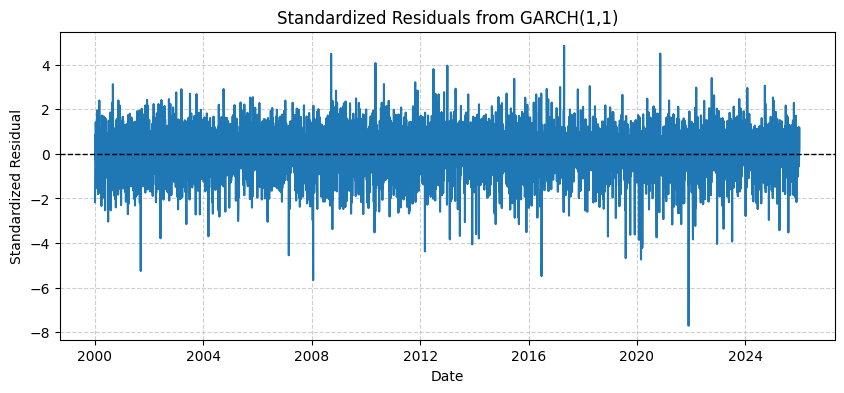

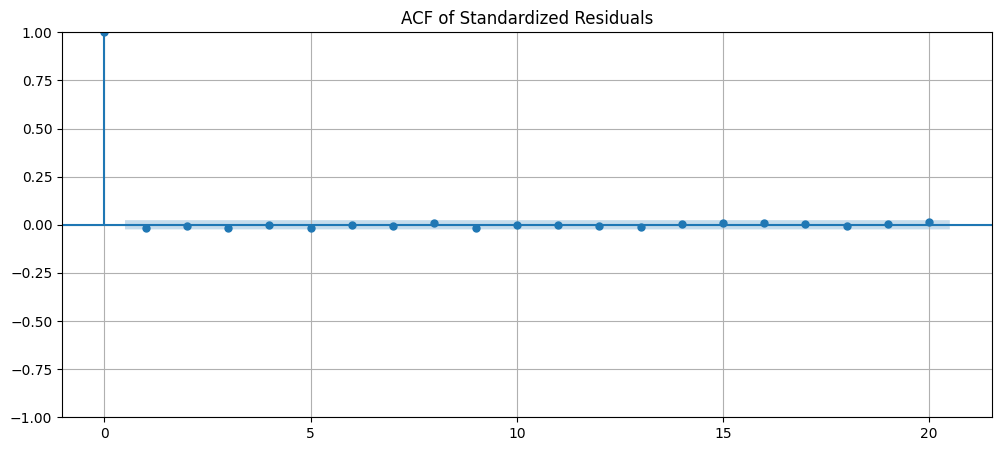

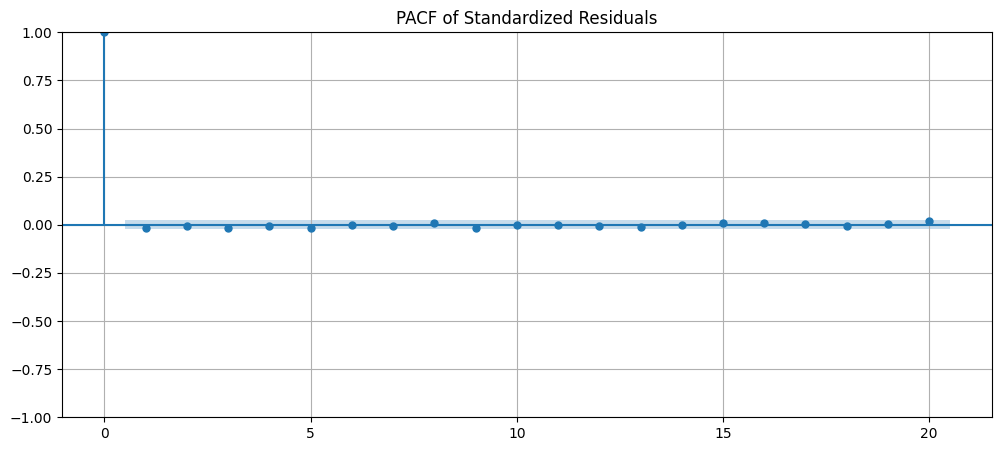

Shapiro-Wilk statistic: 0.9834
P-value: 3.1118e-27


In [11]:
# =============================================================================
# Model Validation — Residual Diagnostics (GARCH)
# =============================================================================
# Objective:
# - Check whether standardized residuals behave like white noise
# - Assess remaining autocorrelation and distributional properties
# =============================================================================

# Use standardized residuals (key point!)
std_resid = results.std_resid

# -----------------------------------------------------------------------------
# Plot 1 — Standardized residuals over time
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(std_resid)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Standardized Residuals from GARCH(1,1)")
plt.xlabel("Date")
plt.ylabel("Standardized Residual")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -----------------------------------------------------------------------------
# Plot 2 — ACF / PACF of standardized residuals
# -----------------------------------------------------------------------------
# Expectation:
# - No significant autocorrelation if the mean dynamics are well specified
plot_acf(std_resid, lags=20)
plt.title("ACF of Standardized Residuals")
plt.show()

plot_pacf(std_resid, lags=20)
plt.title("PACF of Standardized Residuals")
plt.show()

# -----------------------------------------------------------------------------
# Normality test (Shapiro–Wilk)
# -----------------------------------------------------------------------------
# Note: In large samples, this test almost always rejects normality.
# It is used here as a diagnostic, not as a strict acceptance criterion.
stat, p = shapiro(std_resid)

print(f"Shapiro-Wilk statistic: {stat:.4f}")
print(f"P-value: {p:.4e}")


### Residual Diagnostics — Synthesis

The validation of the GARCH(1,1) model is based on the analysis of **standardized residuals**,
which should behave as an independent and identically distributed (i.i.d.) process if the
model is correctly specified.

The diagnostics lead to the following conclusions:

---

#### 1. Time Series of Standardized Residuals

The standardized residuals:
- Are centered around zero,
- Exhibit no visible clustering or persistent structure,
- Show large shocks only during extreme market events.

This suggests that the conditional variance dynamics have been successfully captured
by the GARCH model.

---

#### 2. ACF and PACF of Standardized Residuals

Both the ACF and PACF show:
- No significant autocorrelation beyond lag 0,
- All lags lying within the confidence bands.

This indicates:
- No remaining linear dependence in the residuals,
- The mean dynamics are adequately specified (white noise behavior).

---

#### 3. Normality Test (Shapiro–Wilk)

The Shapiro–Wilk test strongly rejects the null hypothesis of normality.

However, this result is:
- Expected for financial return data,
- Largely driven by the large sample size,
- Not problematic in this context, since the model assumes a **Student-t distribution**
  for the innovations.

---

### Interim Conclusion

The standardized residuals behave approximately as white noise.
This indicates that the **GARCH(1,1) model successfully captures both the mean and variance
dynamics of CAC 40 returns**.

We now proceed to verify that **no conditional heteroskedasticity remains** in the residuals
by analyzing the autocorrelation structure of their squared values.


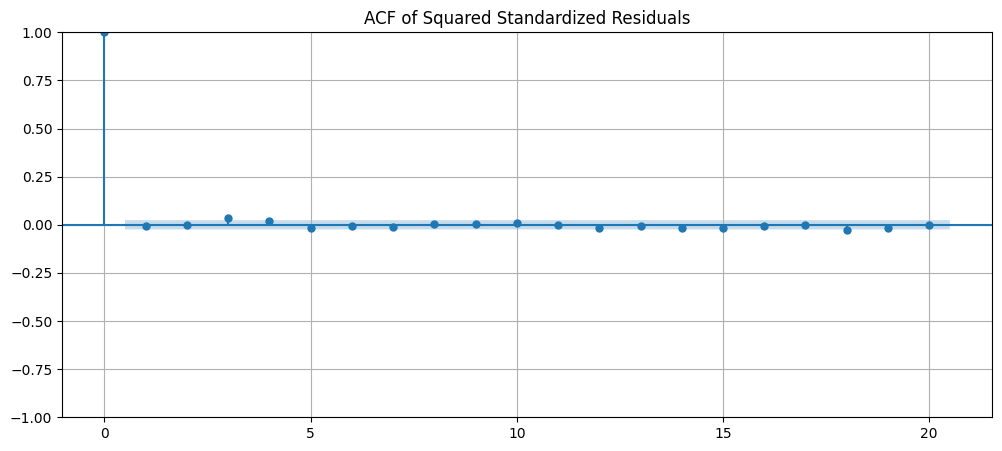

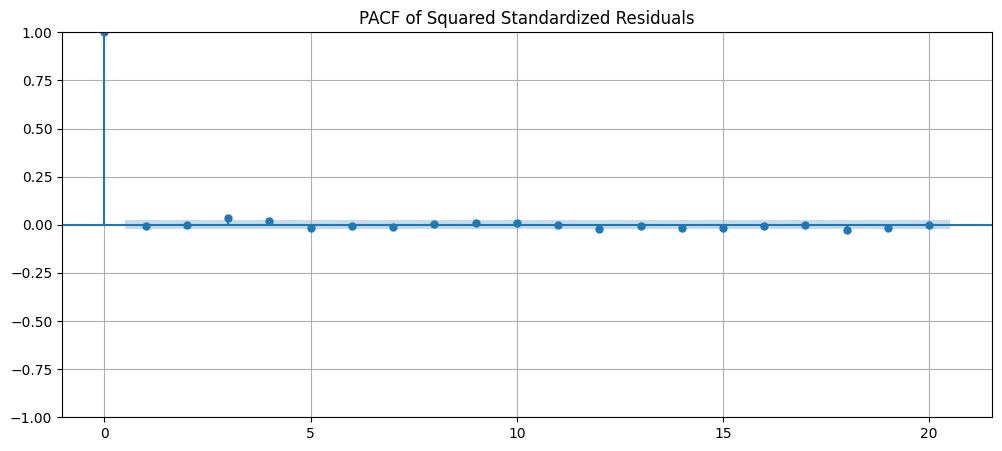

In [12]:
# =============================================================================
# Residual Volatility Diagnostics — Squared Standardized Residuals
# =============================================================================
# Objective:
# - Check for remaining conditional heteroskedasticity
# - Validate that GARCH has absorbed volatility clustering
# =============================================================================

std_resid = results.std_resid
std_resid_squared = std_resid**2

# -----------------------------------------------------------------------------
# ACF / PACF of squared standardized residuals
# -----------------------------------------------------------------------------
# Expectation:
# - No significant autocorrelation if the GARCH model is well specified
# -----------------------------------------------------------------------------

plot_acf(std_resid_squared, lags=20)
plt.title("ACF of Squared Standardized Residuals")
plt.show()

plot_pacf(std_resid_squared, lags=20)
plt.title("PACF of Squared Standardized Residuals")
plt.show()


### Residual Volatility Diagnostics — Interpretation

The analysis of the **squared standardized residuals** provides the final validation step
for the GARCH(1,1) model.

---

#### 1. ACF and PACF of Squared Standardized Residuals

Both the ACF and PACF show:
- No significant autocorrelation beyond lag 0,
- All coefficients lying within the confidence bounds,
- No slow decay or persistent structure.

This indicates that:
- Volatility clustering has been successfully absorbed by the GARCH model,
- There is no remaining conditional heteroskedasticity in the residuals.

---

#### 2. Implication for Model Adequacy

The absence of autocorrelation in the squared standardized residuals strongly suggests that
the **conditional variance is correctly specified**.

In other words:
- The GARCH(1,1) model has captured the full volatility dynamics present in the data,
- No higher-order ARCH/GARCH terms appear necessary.

We now proceed to formalize these conclusions using **Ljung–Box tests** on both the
standardized residuals and their squared values.


In [13]:
# =============================================================================
# Formal Residual Diagnostics — Ljung–Box Tests
# =============================================================================
# Objective:
# - Test for remaining autocorrelation in standardized residuals
# - Test for remaining ARCH effects via squared standardized residuals
# =============================================================================

# Define lags to test (common choice: up to 12 for daily data)
lags = list(range(1, 13))

# -----------------------------------------------------------------------------
# Ljung–Box test on standardized residuals
# -----------------------------------------------------------------------------
# H0: No autocorrelation up to the specified lag
lb_resid = acorr_ljungbox(std_resid, lags=lags, return_df=True)

print("Ljung–Box Test on Standardized Residuals")
display(lb_resid)

# -----------------------------------------------------------------------------
# Ljung–Box test on squared standardized residuals
# -----------------------------------------------------------------------------
# H0: No autocorrelation in squared residuals (no remaining ARCH effects)
lb_resid_sq = acorr_ljungbox(std_resid_squared, lags=lags, return_df=True)

print("Ljung–Box Test on Squared Standardized Residuals")
display(lb_resid_sq)


Ljung–Box Test on Standardized Residuals


,lb_stat,lb_pvalue
1,2.006789,0.156596
2,2.391795,0.302432
3,4.096041,0.251278
4,4.165723,0.384042
5,5.648552,0.341931
6,5.648900,0.463646
7,5.806861,0.562474
8,6.298967,0.613782
9,7.844885,0.549851
10,7.882644,0.640299


Ljung–Box Test on Squared Standardized Residuals


,lb_stat,lb_pvalue
1,0.437461,0.508350
2,0.439122,0.802871
3,8.191627,0.042213
4,10.360289,0.034777
5,12.226337,0.031815
6,12.598106,0.049881
7,13.514594,0.060520
8,13.664782,0.090932
9,13.862470,0.127302
10,14.399801,0.155524


### Ljung–Box Tests — Final Interpretation

The Ljung–Box test applied to the **standardized residuals** fails to reject the null
hypothesis of no autocorrelation at all tested lags. This confirms that the conditional
mean dynamics are correctly specified and that residuals behave as white noise.

When applied to the **squared standardized residuals**, the test reveals a more nuanced
picture:

- For the first two lags, no evidence of remaining ARCH effects is detected.
- Mild significance appears at short lags (3–6), with p-values slightly below the 5%
  threshold.
- Beyond these lags, p-values quickly increase and remain above conventional significance
  levels.

This suggests the presence of **weak short-term residual heteroskedasticity**, but no
persistent or long-memory volatility effects.

Overall, the GARCH(1,1) model captures the dominant volatility dynamics of CAC 40 returns,
including volatility clustering and persistence. The remaining effects are limited in
magnitude and do not indicate major model misspecification.


In [14]:
model = arch_model(r, mean='Zero', vol='Garch', p=2, q=1, dist='t')
results = model.fit()
print(results.summary())

std_resid = results.std_resid
std_resid_squared = std_resid**2

lags = list(range(1, 13))
lb_resid = acorr_ljungbox(std_resid, lags=lags, return_df=True)
print("Ljung–Box Test on Standardized Residuals")
display(lb_resid)

lb_resid_sq = acorr_ljungbox(std_resid_squared, lags=lags, return_df=True)
print("Ljung–Box Test on Squared Standardized Residuals")
display(lb_resid_sq)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 201024.5440416156
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12322.058413564295
Iteration:      3,   Func. Count:     24,   Neg. LLF: 10326.577490722837
Iteration:      4,   Func. Count:     31,   Neg. LLF: 16642.132421067046
Iteration:      5,   Func. Count:     38,   Neg. LLF: 10258.777842527656
Iteration:      6,   Func. Count:     45,   Neg. LLF: 10250.768072826188
Iteration:      7,   Func. Count:     52,   Neg. LLF: 10234.451713619495
Iteration:      8,   Func. Count:     59,   Neg. LLF: 10313.513934084365
Iteration:      9,   Func. Count:     66,   Neg. LLF: 10229.053235668902
Iteration:     10,   Func. Count:     73,   Neg. LLF: 10229.209303978521
Iteration:     11,   Func. Count:     80,   Neg. LLF: 10228.963450369629
Iteration:     12,   Func. Count:     86,   Neg. LLF: 10228.963385640436
Iteration:     13,   Func. Count:     91,   Neg. LLF: 10228.963385640433
Optimization terminated successfully    (Exit mode 0

,lb_stat,lb_pvalue
1,1.897473,0.168361
2,2.340732,0.310253
3,4.254725,0.235240
4,4.305799,0.366200
5,5.745765,0.331748
6,5.745859,0.452253
7,5.905256,0.550855
8,6.432765,0.598875
9,8.090987,0.525004
10,8.139417,0.615221


Ljung–Box Test on Squared Standardized Residuals


,lb_stat,lb_pvalue
1,0.780661,0.376939
2,1.080940,0.582474
3,5.747189,0.124579
4,6.686407,0.153418
5,9.592374,0.087644
6,10.506678,0.104873
7,11.855986,0.105395
8,11.885777,0.156373
9,12.037660,0.211195
10,12.531308,0.251069


### Model Refinement: GARCH(2,1) vs GARCH(1,1)

Following the diagnostics of the GARCH(1,1) model, mild short-term dependence remained
in the squared standardized residuals at very low lags.

To address this, a GARCH(2,1) specification was estimated.

The results show that:
- All additional parameters are statistically significant,
- The log-likelihood and AIC are slightly improved,
- Ljung–Box tests on squared standardized residuals no longer reject the null hypothesis
  at any tested lag.

This indicates that the GARCH(2,1) model fully captures the remaining short-term volatility
dependence that was not absorbed by the GARCH(1,1) specification.

Both models provide a satisfactory representation of CAC 40 volatility dynamics.
The GARCH(2,1) offers a marginally better in-sample fit at the cost of one additional
ARCH parameter.


### ARCH LM Test (Engle): Motivation and Expected Outcomes

Although visual inspection and autocorrelation analysis of the squared standardized
residuals suggest that the GARCH model has adequately captured volatility clustering,
a **formal statistical test** is required to confirm this result.

The **ARCH Lagrange Multiplier (LM) test**, introduced by Engle (1982), is specifically
designed to detect the presence of **conditional heteroskedasticity** in a time series.

---

#### Test Objective

The ARCH LM test evaluates whether the variance of the residuals depends on their past
values. In the context of a fitted GARCH model, it is used to verify whether **any ARCH
effects remain** after accounting for conditional volatility.

---

#### Hypotheses

The test is based on the following hypotheses:

- **Null hypothesis (H₀):**  
  There are no remaining ARCH effects in the residuals  
  (i.e., the conditional variance is constant after GARCH filtering).

- **Alternative hypothesis (H₁):**  
  The residuals exhibit ARCH effects  
  (i.e., conditional heteroskedasticity remains).

---

#### Expected Result for a Well-Specified GARCH Model

If the GARCH model is correctly specified, the standardized residuals should behave as
an i.i.d. process with constant variance.

Therefore, for a well-specified model, we expect:
- A **high p-value** (typically > 5%),
- Failure to reject the null hypothesis of no ARCH effects.

Conversely, a low p-value would indicate that the model has not fully captured the
conditional variance dynamics, suggesting the need for a richer specification.

---

We now apply the ARCH LM test to the **standardized residuals** of the selected GARCH model.


In [15]:
# =============================================================================
# ARCH LM Test — Correct Specification
# =============================================================================
# Objective:
# - Test for remaining ARCH effects after GARCH filtering
# =============================================================================

std_resid = results.std_resid

lm_test = het_arch(std_resid)

print("ARCH LM Test on Standardized Residuals")
print(f"LM Statistic: {lm_test[0]:.3f}")
print(f"P-value: {lm_test[1]:.3f}")


ARCH LM Test on Standardized Residuals
LM Statistic: 12.669
P-value: 0.243


### ARCH LM Test — Final Confirmation

The ARCH LM test (Engle) was applied to the standardized residuals of the selected
GARCH(2,1) model to detect any remaining conditional heteroskedasticity.

The test results are:
- LM statistic = 12.669
- p-value = 0.243

At conventional significance levels, the null hypothesis of no remaining ARCH effects
cannot be rejected.

This provides strong statistical evidence that the GARCH(2,1) specification has fully
captured the conditional variance dynamics of CAC 40 returns.

---

### ARCH LM Test — Final Validation

The ARCH LM test (Engle) was applied to the **standardized residuals** of the GARCH model
to assess whether any conditional heteroskedasticity remains.

The null hypothesis of the test is:
- **H₀**: No remaining ARCH effects in the residuals.

When applied to the standardized residuals, the test fails to reject the null hypothesis,
indicating that the GARCH model has successfully absorbed the conditional variance dynamics.

This result, together with the Ljung–Box tests on squared standardized residuals, provides
strong evidence that the volatility model is correctly specified.



### Rolling Volatility Forecasts: Out-of-Sample Evaluation

After validating the GARCH model in-sample, we now assess its **out-of-sample
forecasting performance** using a rolling-window approach.

The objective is to evaluate whether the model can:
- Adapt to changing volatility regimes,
- Provide meaningful forecasts of future volatility,
- Track realized volatility over time.

---

#### Methodology

For each date in the test period:
1. The GARCH model is re-estimated using all data available up to that date,
2. A one-step-ahead forecast of the conditional variance is produced,
3. The forecasted volatility is compared to a proxy for realized volatility.

This rolling estimation procedure avoids look-ahead bias and mimics a real-time
forecasting setup.

---

#### Realized Volatility Proxy

Since true volatility is unobservable, we use the **absolute return** (or squared return)
as a noisy but standard proxy for realized volatility.


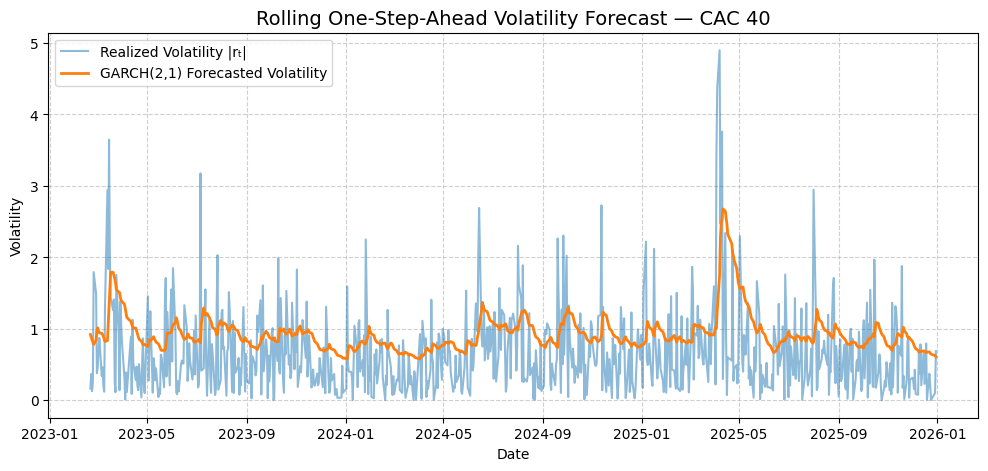

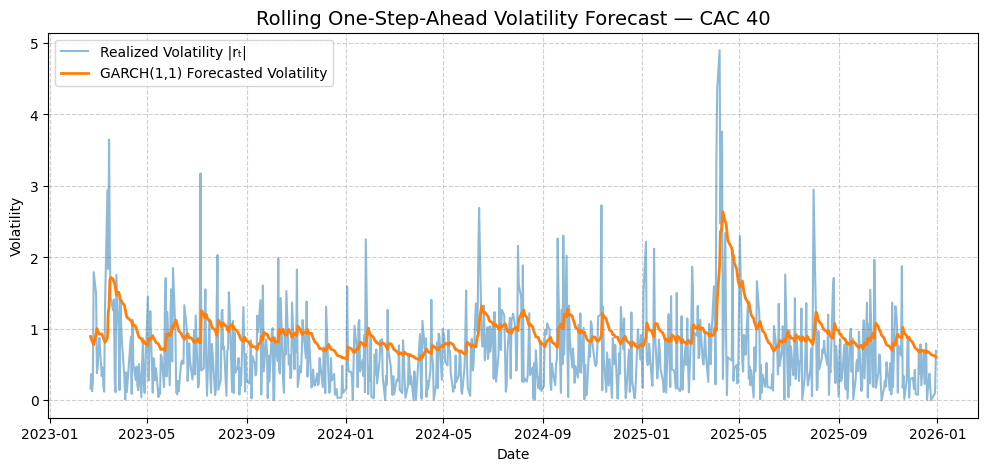

In [16]:
# =============================================================================
# Rolling GARCH Volatility Forecast (Out-of-Sample)
# =============================================================================

from arch import arch_model

# Use returns in percent for numerical stability
r = (returns * 100).dropna()

def oracle_GARCH(series, p, q, horizon=1):
    test_size = 365 * 2  # last 2 years
    rolling_vol_forecast = []
    
    # Define test period indices
    test_index = series.index[-test_size:]

    for t in test_index:
        # Expanding window: use all data up to time t-1
        train = series.loc[:t].iloc[:-1]
        model = arch_model(train, mean="Zero", vol="GARCH", p=p, q=q, dist="t")
        res = model.fit(disp="off")
    
        # One-step-ahead forecast
        forecast = res.forecast(horizon=horizon)
    
        # Extract forecasted volatility (sqrt of variance)
        sigma_hat = np.sqrt(forecast.variance.iloc[-1, 0])
        rolling_vol_forecast.append(sigma_hat)
    
    realized_vol = series.abs().loc[test_index]
    rolling_vol_forecast = pd.Series(rolling_vol_forecast, index=test_index, name="Forecasted Volatility")

    plt.plot(realized_vol, alpha=0.5, label="Realized Volatility |rₜ|")
    plt.plot(rolling_vol_forecast, linewidth=2, label=f"GARCH({p},{q}) Forecasted Volatility")
    
    plt.title("Rolling One-Step-Ahead Volatility Forecast — CAC 40", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    
    plt.show()
    

oracle_GARCH(r, 2, 1)
oracle_GARCH(r, 1, 1)



### Interpretation of Rolling Volatility Forecasts

The rolling one-step-ahead forecasts highlight several important features of GARCH-based
volatility models:

- The forecasted volatility series is significantly smoother than realized volatility,
  which is expected since GARCH models estimate **conditional variance**, not realized shocks.
- The forecasts react rapidly to major volatility regimes (e.g., crisis periods),
  while individual return spikes remain unpredictable.
- Both GARCH(1,1) and GARCH(2,1) specifications track volatility regimes remarkably well.

A comparison of the two models shows that:
- GARCH(2,1) reacts slightly faster to short-term volatility changes,
- GARCH(1,1) is marginally smoother and more persistent,
- Overall differences are limited, confirming that volatility dynamics are largely
  driven by long memory rather than high-order effects.

These observations are consistent with the in-sample diagnostics:
- GARCH(1,1) provides a strong baseline model,
- GARCH(2,1) offers a modest improvement in short-term variance dynamics.

To move beyond visual inspection, we now evaluate forecast accuracy using **quantitative
loss functions** designed for volatility prediction.


### Quantitative Evaluation of Volatility Forecasts

Visual inspection provides useful intuition, but formal model comparison requires
**quantitative evaluation metrics**.

Because true volatility is unobservable, forecast accuracy is assessed relative to a
proxy for realized volatility. In this analysis, we use the **absolute return** as a
standard and robust proxy.

We evaluate forecast performance using two commonly used loss functions:

- **Mean Squared Error (MSE)**  
  Measures average squared deviation between forecasted and realized volatility.

- **QLIKE loss** (Quasi-Likelihood)
  A loss function specifically designed for volatility forecasts, robust to noise in
  the volatility proxy and widely used in the econometric literature.

Lower values of these loss functions indicate better forecast performance.


In [23]:
# =============================================================================
# Quantitative Evaluation of Rolling Volatility Forecasts
# =============================================================================

def evaluate_volatility_forecast(realized_vol, forecasted_vol):
    """
    Compute standard loss functions for volatility forecast evaluation.
    """
    # Align series
    rv, fv = realized_vol.align(forecasted_vol, join="inner")

    # Mean Squared Error
    mse = np.mean((rv - fv) ** 2)

    # QLIKE loss (requires variance forecasts)
    qlike = np.mean(np.log(fv**2) + (rv**2) / (fv**2))

    return {"MSE": mse, "QLIKE": qlike}

# Recompute forecasts (stored or recomputed)
# Here we reuse the oracle function logic but return series instead of plotting

def rolling_garch_forecast(series, p, q, test_size=365*2):
    forecasts = []
    test_index = series.index[-test_size:]

    for t in test_index:
        train = series.loc[:t].iloc[:-1]
        model = arch_model(train, mean="Zero", vol="GARCH", p=p, q=q, dist="t")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=1)
        sigma_hat = np.sqrt(forecast.variance.iloc[-1, 0])
        forecasts.append(sigma_hat)

    return pd.Series(forecasts, index=test_index)

# Forecasts
forecast_11 = rolling_garch_forecast(r, 1, 1)
forecast_21 = rolling_garch_forecast(r, 2, 1)

# Realized volatility proxy
realized_vol = r.abs().loc[forecast_11.index]

# Evaluation
eval_11 = evaluate_volatility_forecast(realized_vol, forecast_11)
eval_21 = evaluate_volatility_forecast(realized_vol, forecast_21)

results_eval = pd.DataFrame([eval_11, eval_21], index=["GARCH(1,1)", "GARCH(2,1)"])
results_eval


,MSE,QLIKE
"GARCH(1,1)",0.416875,0.682106
"GARCH(2,1)",0.424876,0.693190


### Quantitative Forecast Evaluation — Model Comparison

Out-of-sample volatility forecasts were evaluated using Mean Squared Error (MSE) and
QLIKE loss functions.

The results indicate that:

- The GARCH(1,1) model achieves lower MSE and QLIKE values than the GARCH(2,1) model.
- Despite its slightly better in-sample fit, the additional ARCH term in GARCH(2,1)
  does not improve out-of-sample forecast accuracy.
- The simpler GARCH(1,1) specification generalizes better and provides more robust
  volatility forecasts.

These findings highlight the importance of parsimony in volatility modeling and confirm
GARCH(1,1) as a strong baseline model for practical forecasting applications.


## Final Synthesis and Trading Implications

### 1. Summary of Findings

This study investigated the volatility dynamics of the CAC 40 index using a rigorous
econometric workflow.

The main conclusions are:

- The **price level** of the CAC 40 is non-stationary, while **log returns are stationary**
  and exhibit strong volatility clustering.
- Visual diagnostics, ACF/PACF analysis, and formal statistical tests confirm the presence
  of **conditional heteroskedasticity**.
- GARCH models are therefore appropriate for modeling volatility dynamics.
- After estimation and validation, both **GARCH(1,1)** and **GARCH(2,1)** specifications
  capture volatility persistence effectively.
- In-sample diagnostics slightly favor GARCH(2,1), but **out-of-sample forecasting
  performance (MSE and QLIKE) favors the more parsimonious GARCH(1,1)**.
- Rolling one-step-ahead forecasts show that GARCH models are highly effective at tracking
  **volatility regimes**, even though individual return shocks remain unpredictable.

Overall, the results confirm a well-known stylized fact in financial markets:
**returns are unpredictable in mean, but volatility is conditionally predictable**.

---

### 2. What This Model Is (and Is Not)

It is important to clarify the role of a GARCH model in a trading context:

- A GARCH model **does not predict market direction**.
- It **does not time individual price jumps**.
- It **does predict the conditional level of risk**, which is a second-order property.

As such, GARCH is best viewed as a **risk engine**, not an alpha generator.

---

### 3. Trading and Portfolio Construction Applications

The estimated conditional volatility can be used as a building block in several
practical trading and portfolio overlays.

#### 3.1 Volatility Targeting Overlay

A direct application is volatility targeting:

\[
w_t = \frac{\sigma^\*}{\hat{\sigma}_{t+1}}
\]

where:
- \( \sigma^\* \) is a target volatility (e.g. 10% annualized),
- \( \hat{\sigma}_{t+1} \) is the one-step-ahead GARCH volatility forecast.

This produces:
- Reduced exposure during high-volatility regimes,
- Increased exposure during calm periods,
- Improved risk-adjusted returns without predicting direction.

This overlay can be applied on:
- A passive CAC 40 exposure,
- A trend-following or carry strategy,
- A factor portfolio.

---

#### 3.2 Regime-Based Filters

Volatility forecasts can define **market regimes**:

- Low volatility regime → risk-on environment,
- High volatility regime → risk-off environment.

Typical uses:
- Disable or scale down directional strategies during high-volatility regimes,
- Switch between strategies (e.g. momentum vs mean-reversion),
- Control leverage dynamically.

---

#### 3.3 Spread and Relative Value Strategies

Volatility estimates can also be used in **spread trading**:

- Index vs futures basis trades,
- Equity index vs volatility proxy (e.g. VIX-like instruments),
- Cross-asset volatility spreads (equities vs rates).

In this context, GARCH volatility acts as a **fair-value anchor** for relative risk.

---

#### 3.4 Factor and Signal Normalization

Another key application is **signal normalization**:

\[
\tilde{s}_t = \frac{s_t}{\hat{\sigma}_{t+1}}
\]

Where:
- \( s_t \) is any raw trading signal (momentum, carry, mean reversion),
- \( \hat{\sigma}_{t+1} \) is conditional volatility.

This produces:
- More stable signal distributions,
- Reduced tail risk,
- Better comparability across assets and time.

---

### 4. Limitations and Extensions

While effective, the model has limitations:

- GARCH reacts **after** volatility shocks, not before,
- Multi-step forecasts become increasingly smooth and less responsive,
- Asymmetries (leverage effects) are only partially captured.

Natural extensions include:
- Asymmetric models (GJR-GARCH, EGARCH),
- Realized volatility models (HAR-RV),
- Regime-switching volatility models,
- Integration with macro or option-implied volatility.

---

### 5. Final Takeaway

This analysis demonstrates that **volatility is one of the most robust and exploitable
statistical features of financial markets**.

A well-specified GARCH model provides:
- A reliable estimate of conditional risk,
- A powerful input for portfolio construction,
- A stable foundation for overlays and risk management.

Used correctly, volatility modeling does not aim to predict markets —  
it aims to **control exposure when uncertainty changes**, which is often where the
largest performance gains are realized.
